# R. Results
## R.1 Model

## R.2 Features

## R.3 Alternatives

### R.3.1.1 Optimizations:

### R.3.1.2 Results:

# 0. Required dependencies ##
## 0.1 Import necessary libraries...

In [1]:
#surpress sklearn warnings
import warnings
warnings.filterwarnings("ignore")

# standard packages used to handle files
import sys
import os
import glob
import time

# commonly used library for data manipilation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.datasets
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.preprocessing import RobustScaler, Normalizer, PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

import tqdm 

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions kindly provided for you by Matthias
import helpers
# specific helper functions for feature extraction
import features


import mpld3
# tell matplotlib that we plot in a notebook
%matplotlib notebook
mpld3.enable_notebook()

## 0.2 Set file paths

In [2]:
# filepath constants
DATA_BASE_PATH = './'
OUTPUT_PATH='./'


DATA_TRAIN_PATH = os.path.join(DATA_BASE_PATH,'train')
DATA_TEST_PATH = os.path.join(DATA_BASE_PATH,'test')

FEATURE_BASE_PATH = os.path.join(OUTPUT_PATH,'features')
FEATURE_TRAIN_PATH = os.path.join(FEATURE_BASE_PATH,'train')
FEATURE_TEST_PATH = os.path.join(FEATURE_BASE_PATH,'test')

PREDICTION_PATH = os.path.join(OUTPUT_PATH,'predictions')

# filepatterns to write out features
FILEPATTERN_DESCRIPTOR_TRAIN = os.path.join(FEATURE_TRAIN_PATH,'train_features_{}.pkl')
FILEPATTERN_DESCRIPTOR_TEST = os.path.join(FEATURE_TEST_PATH,'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(FEATURE_BASE_PATH)
helpers.createPath(FEATURE_TRAIN_PATH)
helpers.createPath(FEATURE_TEST_PATH)
helpers.createPath(PREDICTION_PATH)

# 1. Loading the data and the labels

In [3]:
# load data and the labels
folder_paths=glob.glob(os.path.join(DATA_TRAIN_PATH,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]

train_paths = dict((label_string, helpers.getImgPaths(os.path.join(DATA_TRAIN_PATH,label_string))) for label_string in label_strings)
test_paths = helpers.getImgPaths(DATA_TEST_PATH)

# 2. Looking at the data

In [ ]:
def flip(image_array):
    if image_array is not None:
        return np.fliplr(image_array)
    else: 
        return None

def addNoise(image_array):
    return skimage.util.random_noise(image_array)

def augmentImage(image_array):
    # construct 4 variations of image
    return [image_array, addNoise(image_array), flip(image_array), addNoise(flip(image_array))]

In [ ]:
def maskForeground(image_array):
    image_array_downsample = np.zeros((int(image_array.shape[1]/2), int(image_array.shape[0]/2)))
    image_array_downsample = cv2.resize(image_array, image_array_downsample.shape, interpolation=cv2.INTER_LINEAR) 

    mask_downsample = np.zeros(image_array_downsample.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    #rect = (int(img.shape[0]*0.05),int(img.shape[1]*0.05) ,int(img.shape[0] - img.shape[0]*0.05 ),int(img.shape[1] - img.shape[1]*0.05))
    rect = (25, 25, image_array.shape[1] - 50, image_array.shape[0] - 50)

    cv2.grabCut(image_array_downsample,mask_downsample,rect,bgdModel,fgdModel,5, cv2.GC_INIT_WITH_RECT)

    mask_downsample = np.where((mask_downsample==2)|(mask_downsample==0),0,1).astype('uint8')
    mask = np.zeros_like(image_array.shape[:2])
    mask = cv2.resize(mask_downsample, image_array.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) 

    thresh = np.sum(mask)/(mask.shape[0] * mask.shape[1])

    if thresh < 0.05 or thresh > 0.55:
        w = image_array.shape[0] / 2
        h = image_array.shape[1] / 2
        image_array = image_array[int(w / 2):int(3*w/2), int(h/2):int(3*h/2), :]
        mask = None
    else:
        mask = mask[:,:,np.newaxis]
        mask = mask.reshape(mask.shape[0], mask.shape[1])
        
    return image_array, mask

In [ ]:
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj,protocol=pickle.HIGHEST_PROTOCOL)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])


def try_to_load_as_pickled_object_or_None(filepath):
    """
    This is a defensive way to write pickle.load, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    try:
        input_size = os.path.getsize(filepath)
        bytes_in = bytearray(0)
        with open(filepath, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        obj = pickle.loads(bytes_in)
    except:
        return None
    return obj

## 2.1 Init descriptor dictionary

In [4]:
descriptor_dict = {
    'surf_aug': features.extractSURFCallback,
    'daisy_aug': features.extractDAISYCallback,
    'sift_aug': features.extractSIFTCallback,
    'vgg_aug': features.extractVGGCallback,
    'freak_aug': features.extractFREAKCallback,
    'orb_aug': features.extractORBCallback,
    'boost_desc_aug': features.extractBoostDescCallback,
    'lucid_aug': features.extractLUCIDCallback,
    'histogram_aug': features.extractHistogramCallback,
    'hu_moments_aug': features.extractHuMomentsCallback,
    'haralick_aug': features.extractHaralickCallback
}

## 2.2 Extract train features

In [ ]:
# train_descriptor_dict = descriptor_dict.copy()

# if the corresponding files already exist, do not extract them again
train_descriptor_dict = dict((key,value) for (key,value) in descriptor_dict.items() if not os.path.isfile(FILEPATTERN_DESCRIPTOR_TRAIN.format(key)))

if len(train_descriptor_dict) > 0: 

    train_features = []
    train_labels = []
    
    # convert train images
    train_features_by_descriptor = dict((key,[]) for (key,value) in train_descriptor_dict.items())
    
    for label_string in label_strings:
        print('extracting train features for class {} :'.format(label_string))
        image_paths, descriptor_dict, label = train_paths[label_string],train_descriptor_dict, label_string

        extracted_features = dict((key, []) for (key, value) in descriptor_dict.items())

        # force python to empty stdout buffers for tqdm progress counter
        sys.stdout.flush()
        for img_path in tqdm.tqdm(image_paths, total=len(image_paths)):
            # load image
            current_image = cv2.imread(img_path)
            #current_image, current_mask = maskForeground(current_image)
            #masks = [current_mask, current_mask, flip(current_mask), flip(current_mask)]
            for (descriptor_name, descriptor_function) in descriptor_dict.items():
                #for current_aug_img in augmentImage(cv2.cvtColor(current_image,cv2.COLOR_BGR2RGB)):
                    #descriptors = descriptor_function(img_as_ubyte(current_aug_img), mask=current_mask)
                    descriptors = descriptor_function(current_image, mask=None)
                    image_features = features.ImageFeatures(img_path, label, descriptors)
                    extracted_features[descriptor_name].append(image_features)
        
    #for descriptor_key in train_features_by_descriptor.keys():
    #    save_as_pickled_object(extracted_features[descriptor_key], FILEPATTERN_DESCRIPTOR_TRAIN.format(descriptor_key))

        for (descriptor_name, descriptor_function) in descriptor_dict.items():
            save_as_pickled_object(extracted_features[descriptor_name], FILEPATTERN_DESCRIPTOR_TRAIN.format('{}_{}'.format(descriptor_name, label_string)))
    
    #for (descriptor_name, descriptor_function) in descriptor_dict.items():
        #save_as_pickled_object(extracted_features[descriptor_name], FILEPATTERN_DESCRIPTOR_TRAIN.format('{}'.format(descriptor_name)))
                    
'''
        # append descriptors of corresponding label to correct descriptor list 
        for key in train_features_by_descriptor.keys():
            train_features_by_descriptor[key]+=extracted_features[key]
'''

In [ ]:
for (descriptor_name, _) in descriptor_dict.items():
    extracted_features = []
    for label in label_strings:
        extracted_features_label = try_to_load_as_pickled_object_or_None(FILEPATTERN_DESCRIPTOR_TRAIN.format('{}_{}'.format(descriptor_name, label)))
        if extracted_features_label is not None:
            extracted_features.extend(extracted_features_label)
    if len(extracted_features) != 0:
        save_as_pickled_object(extracted_features, FILEPATTERN_DESCRIPTOR_TRAIN.format('{}'.format(descriptor_name)))
    

## 2.3 Extract test features

In [ ]:
test_paths = helpers.getImgPaths(DATA_TEST_PATH)

test_descriptor_dict=dict((key,value) for (key,value) in descriptor_dict.items() if not os.path.isfile(FILEPATTERN_DESCRIPTOR_TEST.format(key)))

if len(test_descriptor_dict) > 0: 
    test_features = []
    
    print('extracting test features:') 
    
    image_paths, descriptor_dict, label = test_paths,test_descriptor_dict, None
    
    extracted_features = dict((key, []) for (key, value) in descriptor_dict.items())

    # force python to empty stdout buffers for tqdm progress counter
    sys.stdout.flush()
    for img_path in tqdm.tqdm(image_paths, total=len(image_paths)):
        # load image
        current_image = cv2.imread(img_path)
        current_image, current_mask = maskForeground(current_image)
        for (descriptor_name, descriptor_function) in descriptor_dict.items():
            descriptors = descriptor_function(current_image, mask=current_mask)
            #descriptors = descriptor_function(current_image, mask=None)
            image_features = features.ImageFeatures(img_path, label, descriptors)
            extracted_features[descriptor_name].append(image_features)

    for (descriptor_name, descriptor_function) in descriptor_dict.items():
        save_as_pickled_object(extracted_features[descriptor_name], FILEPATTERN_DESCRIPTOR_TEST.format('{}'.format(descriptor_name)))

# 3. Using the provided image features


## 3.1 Load train- and testfeatures per image

In [4]:
def encodeImages(descriptor):
    descriptor_desired=descriptor
    with open(FILEPATTERN_DESCRIPTOR_TRAIN.format(descriptor_desired),'rb') as pkl_file_train:
        train_features_from_pkl=pickle.load(pkl_file_train)
        
    print('\tNumber of {} encoded train images: {}'.format(desc, len(train_features_from_pkl)))
    
    with open(FILEPATTERN_DESCRIPTOR_TEST.format(descriptor_desired),'rb') as pkl_file_test:
        test_features_from_pkl = pickle.load(pkl_file_test)

    print('\tNumber of {} encoded test images: {}'.format(desc, len(test_features_from_pkl)))

    return train_features_from_pkl, test_features_from_pkl

## 3.2 Create codebook

In [5]:
def getCodebook(codebook_size, train_features):
    clustered_codebook = helpers.createCodebook(train_features, codebook_size=codebook_size)

    return clustered_codebook

## 3.3 Encode image features with codebooks

In [6]:
canine_label_strings=['dalmatian', 'german_shepherd', 'chihuahua', 'wolf', 'collie', 'feline']
feline_label_strings=['bobcat', 'lion', 'tiger', 'leopard', 'persian_cat', 'siamese_cat', 'canine']
distinct_label_strings=['canine', 'feline']
label_strings=['bobcat', 'chihuahua','collie', 'dalmatian', 'german_shepherd', 'leopard', 'lion', 'persian_cat', 'siamese_cat', 'tiger', 'wolf']

def decodeLabel(label):
    if type(label) is np.bytes_:
        label = label.decode("UTF-8") 
    return label

def getImageFeatures(feature_amount, train_features, test_features):
    print('\tFixing features')
    # fix image features
    for i, train_feature in reversed(list(enumerate(train_features))):
        if type(train_feature.data) is not np.ndarray:
            train_features[i] = train_features[i]._replace(data=np.zeros((1, train_features[0].data.shape[1])).reshape(1, -1))
        elif (type(train_feature.data) is np.ndarray and len(train_feature.data.shape) is 1):
            train_features[i] = train_features[i]._replace(data=np.array(train_feature.data).reshape(1, -1))
            
    for i, test_feature in reversed(list(enumerate(test_features))):
        if type(test_feature.data) is not np.ndarray:
            test_features[i] = train_features[i]._replace(data=np.zeros((1, test_features[0].data.shape[1])).reshape(1, -1))
        elif (type(test_feature.data) is np.ndarray and len(test_feature.data.shape) is 1):
            test_features[i] = test_features[i]._replace(data=np.array(test_feature.data).reshape(1, -1))
            
    # generate codebooks for different features
    print('\tGenerating codebooks...')
    canine_train_features = []
    feline_train_features = []
    for image_features in train_features:
        label = decodeLabel(image_features.label)
        if label in canine_label_strings:
            canine_train_features.append(image_features)
        elif label in feline_label_strings:
            feline_train_features.append(image_features)
    
    clustered_codebook = getCodebook(feature_amount, train_features)
    canine_clustered_codebook = getCodebook(feature_amount, canine_train_features)
    feline_clustered_codebook = getCodebook(feature_amount, feline_train_features)
    
    
    # encode all train images 
    train_data=[]
    train_labels=[]
    
    canine_train_data=[]
    canine_train_labels=[]
    
    feline_train_data=[]
    feline_train_labels=[]
    
    train_labels_true=[]
    
    print('\tExtracting all image features...')
    for image_features in train_features:
        label = decodeLabel(image_features.label)
        train_labels_true.append(label)
        
        data = image_features.data
        # extract canine image features
        if label in canine_label_strings:
            bow_feature_vector = helpers.encodeImage(data,canine_clustered_codebook)
            canine_train_data.append(bow_feature_vector)
            canine_train_labels.append(label) 
            
            bow_feature_vector = helpers.encodeImage(data,feline_clustered_codebook)
            feline_train_data.append(bow_feature_vector)
            feline_train_labels.append('canine')
        # extract feline image features
        elif label in feline_label_strings:
            bow_feature_vector = helpers.encodeImage(data,feline_clustered_codebook)
            feline_train_data.append(bow_feature_vector)
            feline_train_labels.append(label)
            
            bow_feature_vector = helpers.encodeImage(data,canine_clustered_codebook)
            canine_train_data.append(bow_feature_vector)
            canine_train_labels.append('feline')
        else: 
            raise Exception('{} is not canine nor feline'.format(image_features.label))
            
        # extract distinct image features
        bow_feature_vector = helpers.encodeImage(data,clustered_codebook)
        train_data.append(bow_feature_vector)
        if label in canine_label_strings:
            train_labels.append('canine')
        else:
            train_labels.append('feline')
    
    
    # use a labelencoder to obtain numerical labels
    print('\tEncoding label strings...')
    label_encoder = sklearn.preprocessing.LabelEncoder()
    label_encoder.fit(distinct_label_strings)
    train_labels = label_encoder.transform(train_labels)   
    
    canine_label_encoder = sklearn.preprocessing.LabelEncoder()
    canine_label_encoder.fit(canine_label_strings)
    canine_train_labels = canine_label_encoder.transform(canine_train_labels)  
    
    feline_label_encoder = sklearn.preprocessing.LabelEncoder()
    feline_label_encoder.fit(feline_label_strings)
    feline_train_labels = feline_label_encoder.transform(feline_train_labels)  

    label_encoder_true = sklearn.preprocessing.LabelEncoder()
    label_encoder_true.fit(label_strings)
    train_labels_true = label_encoder_true.transform(train_labels_true)   
        
    # encode all test images 
    print('\tEncoding test data...')
    test_data=[]
    canine_test_data=[]
    feline_test_data=[]
    for image_features in test_features:
        bow_feature_vector=helpers.encodeImage(image_features.data,clustered_codebook)
        test_data.append(bow_feature_vector)

        bow_feature_vector=helpers.encodeImage(image_features.data,canine_clustered_codebook)
        canine_test_data.append(bow_feature_vector)
        
        bow_feature_vector=helpers.encodeImage(image_features.data,feline_clustered_codebook)
        feline_test_data.append(bow_feature_vector)
        
    
    # return data
    return train_data, train_labels, test_data, canine_train_data, canine_train_labels, canine_test_data, feline_train_data, feline_train_labels, feline_test_data, train_labels_true


## 3.4 Transform features

In [7]:
def transformImageFeatures(X, y, X_test):
    normalizer = Normalizer()
    pca = PCA(svd_solver='full', n_components = 0.78)
    X_tf = pca.fit_transform(normalizer.fit_transform(X), y)
    X_test_tf = pca.transform(normalizer.transform(X_test))
    
    return X_tf, X_test_tf


# 4. Training model

## 4.0 Data splitting

In [8]:
def splitData(X, y, test_size = 0.25):
    indices = list(range(len(X[0::4])))
    train_indices, test_indices, _, _ = train_test_split(indices, y[0::4], test_size = test_size, stratify=y[0::4])

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for i in train_indices:
        X_train.extend(X[4*i:4*(i+1)])
        y_train.extend(y[4*i:4*(i+1)])
    for j in test_indices:
        X_test.extend(X[4*j:4*(j+1)])
        y_test.extend(y[4*j:4*(j+1)])
        
    p_train = np.random.permutation(len(X_train))
    p_test = np.random.permutation(len(X_test))
    
    return np.array(X_train)[p_train].tolist(), np.array(X_test)[p_test].tolist(), np.array(y_train)[p_train].tolist(), np.array(y_test)[p_test].tolist()
    

## 4.1 Training

In [9]:
def getTrainedModel(model, X_train, y_train):
    model.fit(X_train,y_train)
    return model

## 4.2 Optimize performance

In [10]:
def getBestParams(model, X, y, nfolds):
    pca__n_components = [x / 1000 for x in list(range(680, 740, 1))]
    Cs = [x / 100 for x in list(range(190, 220, 1))]
    print([x / 100 for x in list(range(190, 220, 1))])
    print([x / 1000 for x in list(range(680, 740, 1))])
    param_grid = {'pca__n_components': pca__n_components, 'logregcv__C': Cs}
    grid_search = GridSearchCV(model, param_grid, cv=nfolds)
    grid_search.fit(X, y)
    print(grid_search.best_params_)
    return grid_search.best_params_


## 4.3 Estimate performance

In [11]:
def getLogLoss(model, X, y):
    logloss = sklearn.metrics.log_loss(y, makePrediction(model, X), labels=y)
    return logloss

def loglossCV(model, X, y, test_size, n_folds):
    print('Calculating logloss...')
    
    loglosses = []
    for i in range(n_folds): 
        print('\t{}.1: Splitting data...'.format(i))
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test_size, stratify=y)
        
        print('\t{}.2: Training model...'.format(i))
        val_model = getTrainedModel(model, X_train, y_train)  
        
        print('\t{}.3: Calculating logloss...'.format(i)) 
        logloss = getLogLoss(model = val_model, X = X_val, y = y_val)
        print('\t{}.4: Logloss is {}.'.format(i, logloss))
        loglosses.append(logloss)
    return np.mean(loglosses)

def getAccuracy(model, X_train, X_test, y_train, y_test, n_folds):
    training_accuracy = model.score(X_train, y_train)
    print("Training data accuracy:",training_accuracy)

    validation_accuracy = cross_val_score(model, X_val, y_val, cv=n_folds)
    print("Cross-validation score (mean):", validation_accuracy.mean())
    print("Cross-validation score (std.dev.):", validation_accuracy.std())

## 4.4 Make prediction

In [12]:
def makePrediction(model, X):
    predictions = model.predict_proba(X)

    """
    for prediction in predictions:
        if prediction.any() >= 0.90:
            for i, pred in enumerate(prediction):
                if pred >= 0.90:
                    prediction[i] = 1
                else:
                    prediction[i] = 0
    """

    return predictions

def submitPrediction(prediction):
    pred_file_path = os.path.join(PREDICTION_PATH, helpers.generateUniqueFilename('simplelinear7','csv'))
    helpers.writePredictionsToCsv(prediction,pred_file_path,label_strings)

# 5. Visualize results

In [13]:
"""Plot learning curve"""
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    titlepar = {'weight' : 'bold',
            'size' : '15'}
    ypara = {'weight' : 'bold',
             'rotation' : '0'}
    xpara = {'weight' : 'bold'}
    plt.title(title, **titlepar)
    plt.xlabel("Amount of training images", **xpara)
    plt.ylabel("Score", **ypara).set_position([-1.5, 0.45])
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring='neg_log_loss', cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross validation score")
    plt.legend(loc="best")
    plt.show()

"""Plot ROC"""
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def plotROC(x, y, nameofTest, test, cv):
    y_bin = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8,9,10])
    n_classes = y_bin.shape[1]
    
    pipeline= Pipeline([('scaler', StandardScaler()), (nameofTest, test)])
    y_score = cross_val_predict(pipeline, x, y, cv=cv ,method='predict_proba')
    f = dict()
    t = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        f[i], t[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(f[i], t[i])
    colors =(['blue', 'red', 'green','yellow', 'black','coral','orange','cyan','peachpuff','deeppink','forestgreen'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(f[i], t[i], color=color, lw=3,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(label_strings[i], roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=3)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    titlepar = {'weight' : 'bold',
            'size' : '15'}
    ypara = {'weight' : 'bold',
             'rotation' : '0',}
    xpara = {'weight' : 'bold'}
    plt.xlabel('False Positive Rate', **xpara)
    plt.ylabel('True Positive \n Rate', **ypara).set_position([-1, 0.43])
    plt.title('ROC for image classification', **titlepar)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

"""Confusion matrix"""
import itertools

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    titlepar = {'weight' : 'bold',
            'size' : '20'}
    ypara = {'weight' : 'bold',
             'rotation' : '0',
             'size' : '14'}
    xpara = {'weight' : 'bold',
             'size' : '14'}
    plt.ylabel('True label', **ypara)
    plt.xlabel('Predicted label', **xpara)
    plt.title(title, **titlepar)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, weight='bold')
    plt.yticks(tick_marks, classes, weight = 'bold')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

def plot_confusion_matrix(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_true = y_test
    y_pred = model.predict(x_test)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    
    # Plot non-normalized confusion matrix
    plt.figure(figsize = (20, 20))
    plot_conf_matrix(cnf_matrix, classes=label_strings,
                          title='Confusion matrix (%)')
    
    # Plot normalized confusion matrix
    plt.figure(figsize = (20, 20))
    plot_conf_matrix(cnf_matrix, classes=label_strings, normalize=True,
                          title='Normalized confusion matrix')


"""Plot boxplot of average cv_score of some models"""

"""different models to test are saved in models[], see example below"""
modelsList = []
modelsList.append(('Logistic Regression', LogisticRegression()))
modelsList.append(('Logistic Regression CV implemented', LogisticRegressionCV()))

def first_impression_model_comparison(modelsList, x_train, y_train, cv):
    results=[]
    names=[]
    scoring = 'accuracy'
    for name, model in modelsList:
        cv_results = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
        results.append(cv_results)
        names.append(name)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    titlepar = {'weight' : 'bold',
            'size' : '15'}
    ypara = {'weight' : 'bold',
             'rotation' : '0',}
    plt.ylabel("Cross validation score", **ypara).set_position([-1.5, 1.01])
    plt.title("Cross validation score per model", **titlepar)
    plt.ylim(ymin = 0.30, ymax = 0.50)
    xpara = {'rotation' : '40',
             'ha' : 'right'}

# 6. Build and run construted model

## 6.0 Retrieve feature data

In [14]:
descriptors = {
    'surf_aug': True,
    'daisy_aug': True,
    'sift_aug': True,
    'vgg_aug': True,
    'freak_aug': True,
    'orb_aug': True,
    'boost_desc_aug': True,
    'lucid_aug': True,
    'histogram_aug': True,
    'hu_moments_aug': True,
    'haralick_aug': True
}

In [15]:
X, X_test, X_canine, X_canine_test, X_feline, X_feline_test = None, None, None, None, None, None


In [17]:
for desc in list(descriptors.keys()):
    print('Loading {} descriptor...'.format(desc))
    if descriptors[desc]:
        # encode features
        train_features, test_features = encodeImages(desc)
        if desc is 'histogram':
            for i, train_feature in enumerate(train_features):
                train_features[i] = train_features[i]._replace(data=np.array(train_feature.data).reshape(1, -1))
            for j, test_feature in enumerate(test_features):
                test_features[j] = train_features[j]._replace(data=np.array(test_feature.data).reshape(1, -1))
        X_desc, y_desc, X_test_desc, X_canine_desc, y_canine_desc, X_canine_test_desc, X_feline_desc, y_feline_desc, X_feline_test_desc, y_true_desc = getImageFeatures(860, train_features[0::4], test_features)

        X_desc_tf, X_test_desc_tf = X_desc, X_test_desc
        X_canine_desc_tf, X_canine_test_desc_tf = X_canine_desc, X_canine_test_desc
        X_feline_desc_tf, X_feline_test_desc_tf = X_feline_desc, X_feline_test_desc
        
        # add train features to data list
        if X is None:
            X = X_desc_tf
        else:
            X = np.concatenate((X, X_desc_tf), axis = 1)
        
        if X_canine is None:
            X_canine = X_canine_desc_tf
        else:
            X_canine = np.concatenate((X_canine, X_canine_desc_tf), axis = 1)
        
        if X_feline is None:
            X_feline = X_feline_desc_tf
        else:
            X_feline = np.concatenate((X_feline, X_feline_desc_tf), axis = 1)
        
        
        # add test features to data list
        if X_test is None:
            X_test = X_test_desc_tf
        else:
            X_test = np.concatenate((X_test, X_test_desc_tf), axis = 1)
            
        if X_canine_test is None:
            X_canine_test = X_canine_test_desc_tf
        else:
            X_canine_test = np.concatenate((X_canine_test, X_canine_test_desc_tf), axis = 1)
            
        if X_feline_test is None:
            X_feline_test = X_feline_test_desc_tf
        else:
            X_feline_test = np.concatenate((X_feline_test, X_feline_test_desc_tf), axis = 1)
            

Loading surf_aug descriptor...
	Number of surf_aug encoded train images: 14224
	Number of surf_aug encoded test images: 3550
	Fixing features
	Generating codebooks...
	Training took 456.8813750743866 seconds
	Training took 111.98153400421143 seconds
	Training took 284.37118697166443 seconds
	Extracting all image features...
	Encoding label strings...
	Encoding test data...
Loading daisy_aug descriptor...
	Number of daisy_aug encoded train images: 14224
	Number of daisy_aug encoded test images: 3550
	Fixing features
	Generating codebooks...
	Training took 153.0911829471588 seconds
	Training took 68.60707187652588 seconds
	Training took 105.10730290412903 seconds
	Extracting all image features...
	Encoding label strings...
	Encoding test data...
Loading sift_aug descriptor...
	Number of sift_aug encoded train images: 14224
	Number of sift_aug encoded test images: 3550
	Fixing features
	Generating codebooks...
	Training took 168.80771899223328 seconds
	Training took 65.83677315711975 seco

In [18]:
y = y_desc
y_true = y_true_desc
y_canine = y_canine_desc
y_feline = y_feline_desc

## 6.1 Split data in train, test, meta train and meta test sets

## 6.2 Define base and meta models

In [19]:
# split data by indices
train_idx, val_idx, _, _ = train_test_split(range(len(X)), y, test_size = 889, stratify=y)

# over sample training data
sm = SMOTE(sampling_strategy = 'not majority')
train_idx, _ = sm.fit_resample(np.array(train_idx).reshape(-1,1), y_true[train_idx])
train_idx = train_idx.reshape(-1,)
np.random.shuffle(train_idx)

# TRAIN AND TEST DATA
# split distiction data
X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[val_idx]
y_val = y[val_idx]

# split canine data
X_canine_train = X_canine[train_idx]
y_canine_train = y_canine[train_idx]
X_canine_val = X_canine[val_idx]
y_canine_val = y_canine[val_idx]

# split feline data
X_feline_train = X_feline[train_idx]
y_feline_train = y_feline[train_idx]
X_feline_val = X_feline[val_idx]
y_feline_val = y_feline[val_idx]

## META TRAIN AND TEST DATA
# true labels
y_train_meta = y_true[train_idx]
y_val_meta = y_true[val_idx]

# init meta data
X_train_meta = np.zeros((X_train.shape[0], X_train.shape[1] + 13))
X_train_meta[:,:X_val.shape[1]] = X_train
X_val_meta = np.zeros((X_val.shape[0], X_val.shape[1] + 13))
X_val_meta[:,:X_val.shape[1]] = X_val


In [20]:
model = SVC(C = 70, cache_size=10000, kernel = 'rbf', gamma='scale', probability = True)
canine_model = SVC(C = 70, cache_size=10000, kernel = 'rbf', gamma='scale', probability = True)
feline_model = SVC(C = 65, cache_size=10000, kernel = 'rbf', gamma='scale', probability = True)


## 6.3 Split train data in folds, train base models on the train folds and predict the validation fold to retrieve meta train data

In [22]:
# DEFINE FOLDS
kf = KFold(n_splits=5, shuffle=False)
train_folds = []
val_folds = []
for fold_train_idx, fold_val_idx in kf.split(train_idx):
    train_folds.append(fold_train_idx)
    val_folds.append(fold_val_idx)
    
## TRAIN MODELS ON FOLDS
for fold_idx in range(5):
    print('Training {}.1...'.format(fold_idx))
    model.fit(X_train[train_folds[fold_idx]], y_train[train_folds[fold_idx]])
    fold_pred = model.predict_proba(X_train[val_folds[fold_idx]])
    X_train_meta[val_folds[fold_idx]][:, X_train.shape[1]:X_train.shape[1]+2] = fold_pred

    print('Training {}.2...'.format(fold_idx))
    canine_model.fit(X_canine_train[train_folds[fold_idx]], y_canine_train[train_folds[fold_idx]])
    fold_canine_pred = canine_model.predict_proba(X_canine_train[val_folds[fold_idx]])
    X_train_meta[val_folds[fold_idx]][:, X_train.shape[1]+2:X_train.shape[1]+7] = fold_canine_pred[:, :-1]

    print('Training {}.3...'.format(fold_idx))
    feline_model.fit(X_feline_train[train_folds[fold_idx]], y_feline_train[train_folds[fold_idx]])
    fold_feline_pred = feline_model.predict_proba(X_feline_train[val_folds[fold_idx]])
    X_train_meta[val_folds[fold_idx]][:, X_train.shape[1]+7:X_train.shape[1]+13] = fold_feline_pred[:, :-1]

Training 0.1...
Training 0.2...
Training 0.3...
Training 1.1...
Training 1.2...
Training 1.3...
Training 2.1...
Training 2.2...
Training 2.3...
Training 3.1...
Training 3.2...
Training 3.3...
Training 4.1...
Training 4.2...
Training 4.3...


## 6.4 Retrieve meta validation data by training base models on full train data set and predicting the full validation data

In [ ]:
# GENERATE TEST DATA
print('Training 0...')
model.fit(X_train, y_train)
pred = model.predict_proba(X_val)
X_val_meta[:][:, X_train.shape[1]:X_train.shape[1]+2] = pred

print('Training 1...')
canine_model.fit(X_canine_train, y_canine_train)
canine_pred = canine_model.predict_proba(X_canine_val)
X_val_meta[:][:, X_train.shape[1]+2:X_train.shape[1]+7] = canine_pred[:, :-1]

print('Training 2...')
feline_model.fit(X_feline_train, y_feline_train)
feline_pred = feline_model.predict_proba(X_feline_val)
X_val_meta[:][:, X_train.shape[1]+7:X_train.shape[1]+13] = feline_pred[:, :-1]


Training 0...
Training 1...
Training 2...


## 6.5 Train meta model on meta train data 

In [ ]:
# DEFINE META MODEL
meta_model = SVC(C = 50, cache_size=1000, kernel = 'rbf', tol = 0.001, gamma='scale', probability = True)

# TRAIN META MODEL
meta_model.fit(X_train_meta, y_train_meta)

## 6.6 Make prediction on meta validation data with meta model for final prediction

In [ ]:
# LOG LOSS OF META PREDICTOR
meta_pred = meta_model.predict_proba(X_val_meta)


## 6.7 Calculate log loss

In [ ]:
print(sklearn.metrics.log_loss(y_val_meta, meta_pred, labels=y_val_meta))


## 6.8 Evaluate model

<IPython.core.display.Javascript object>


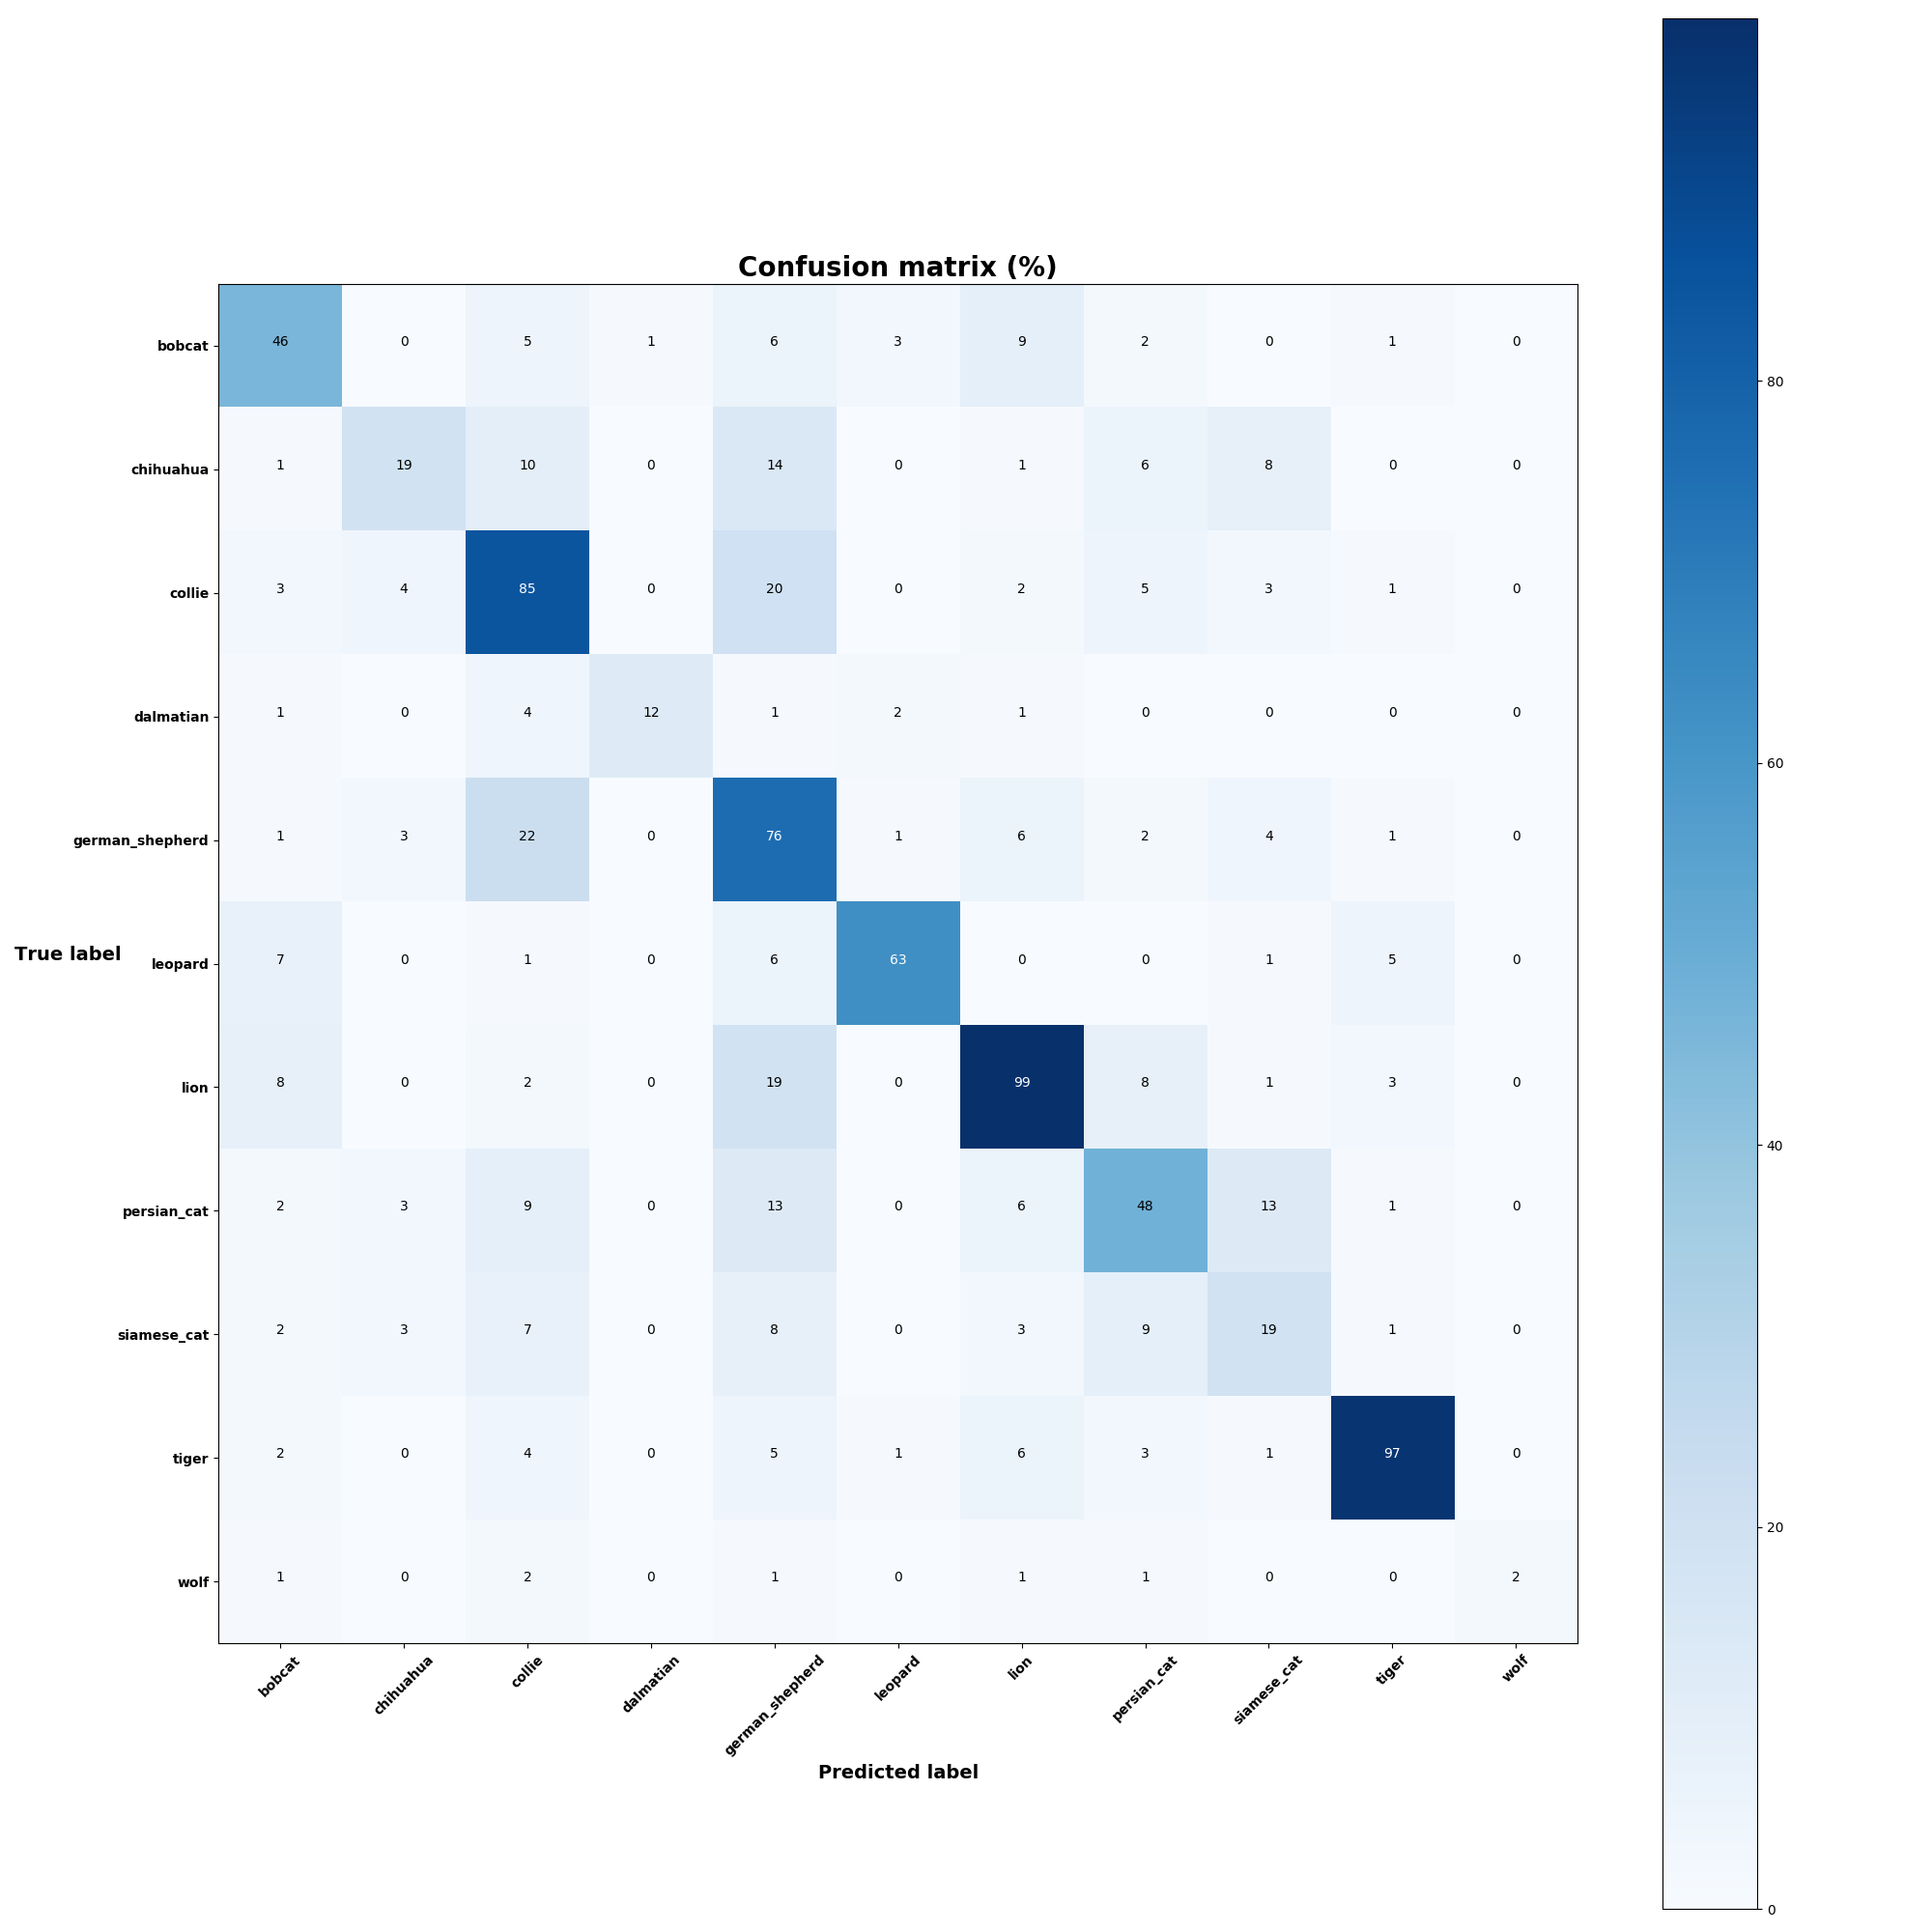

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


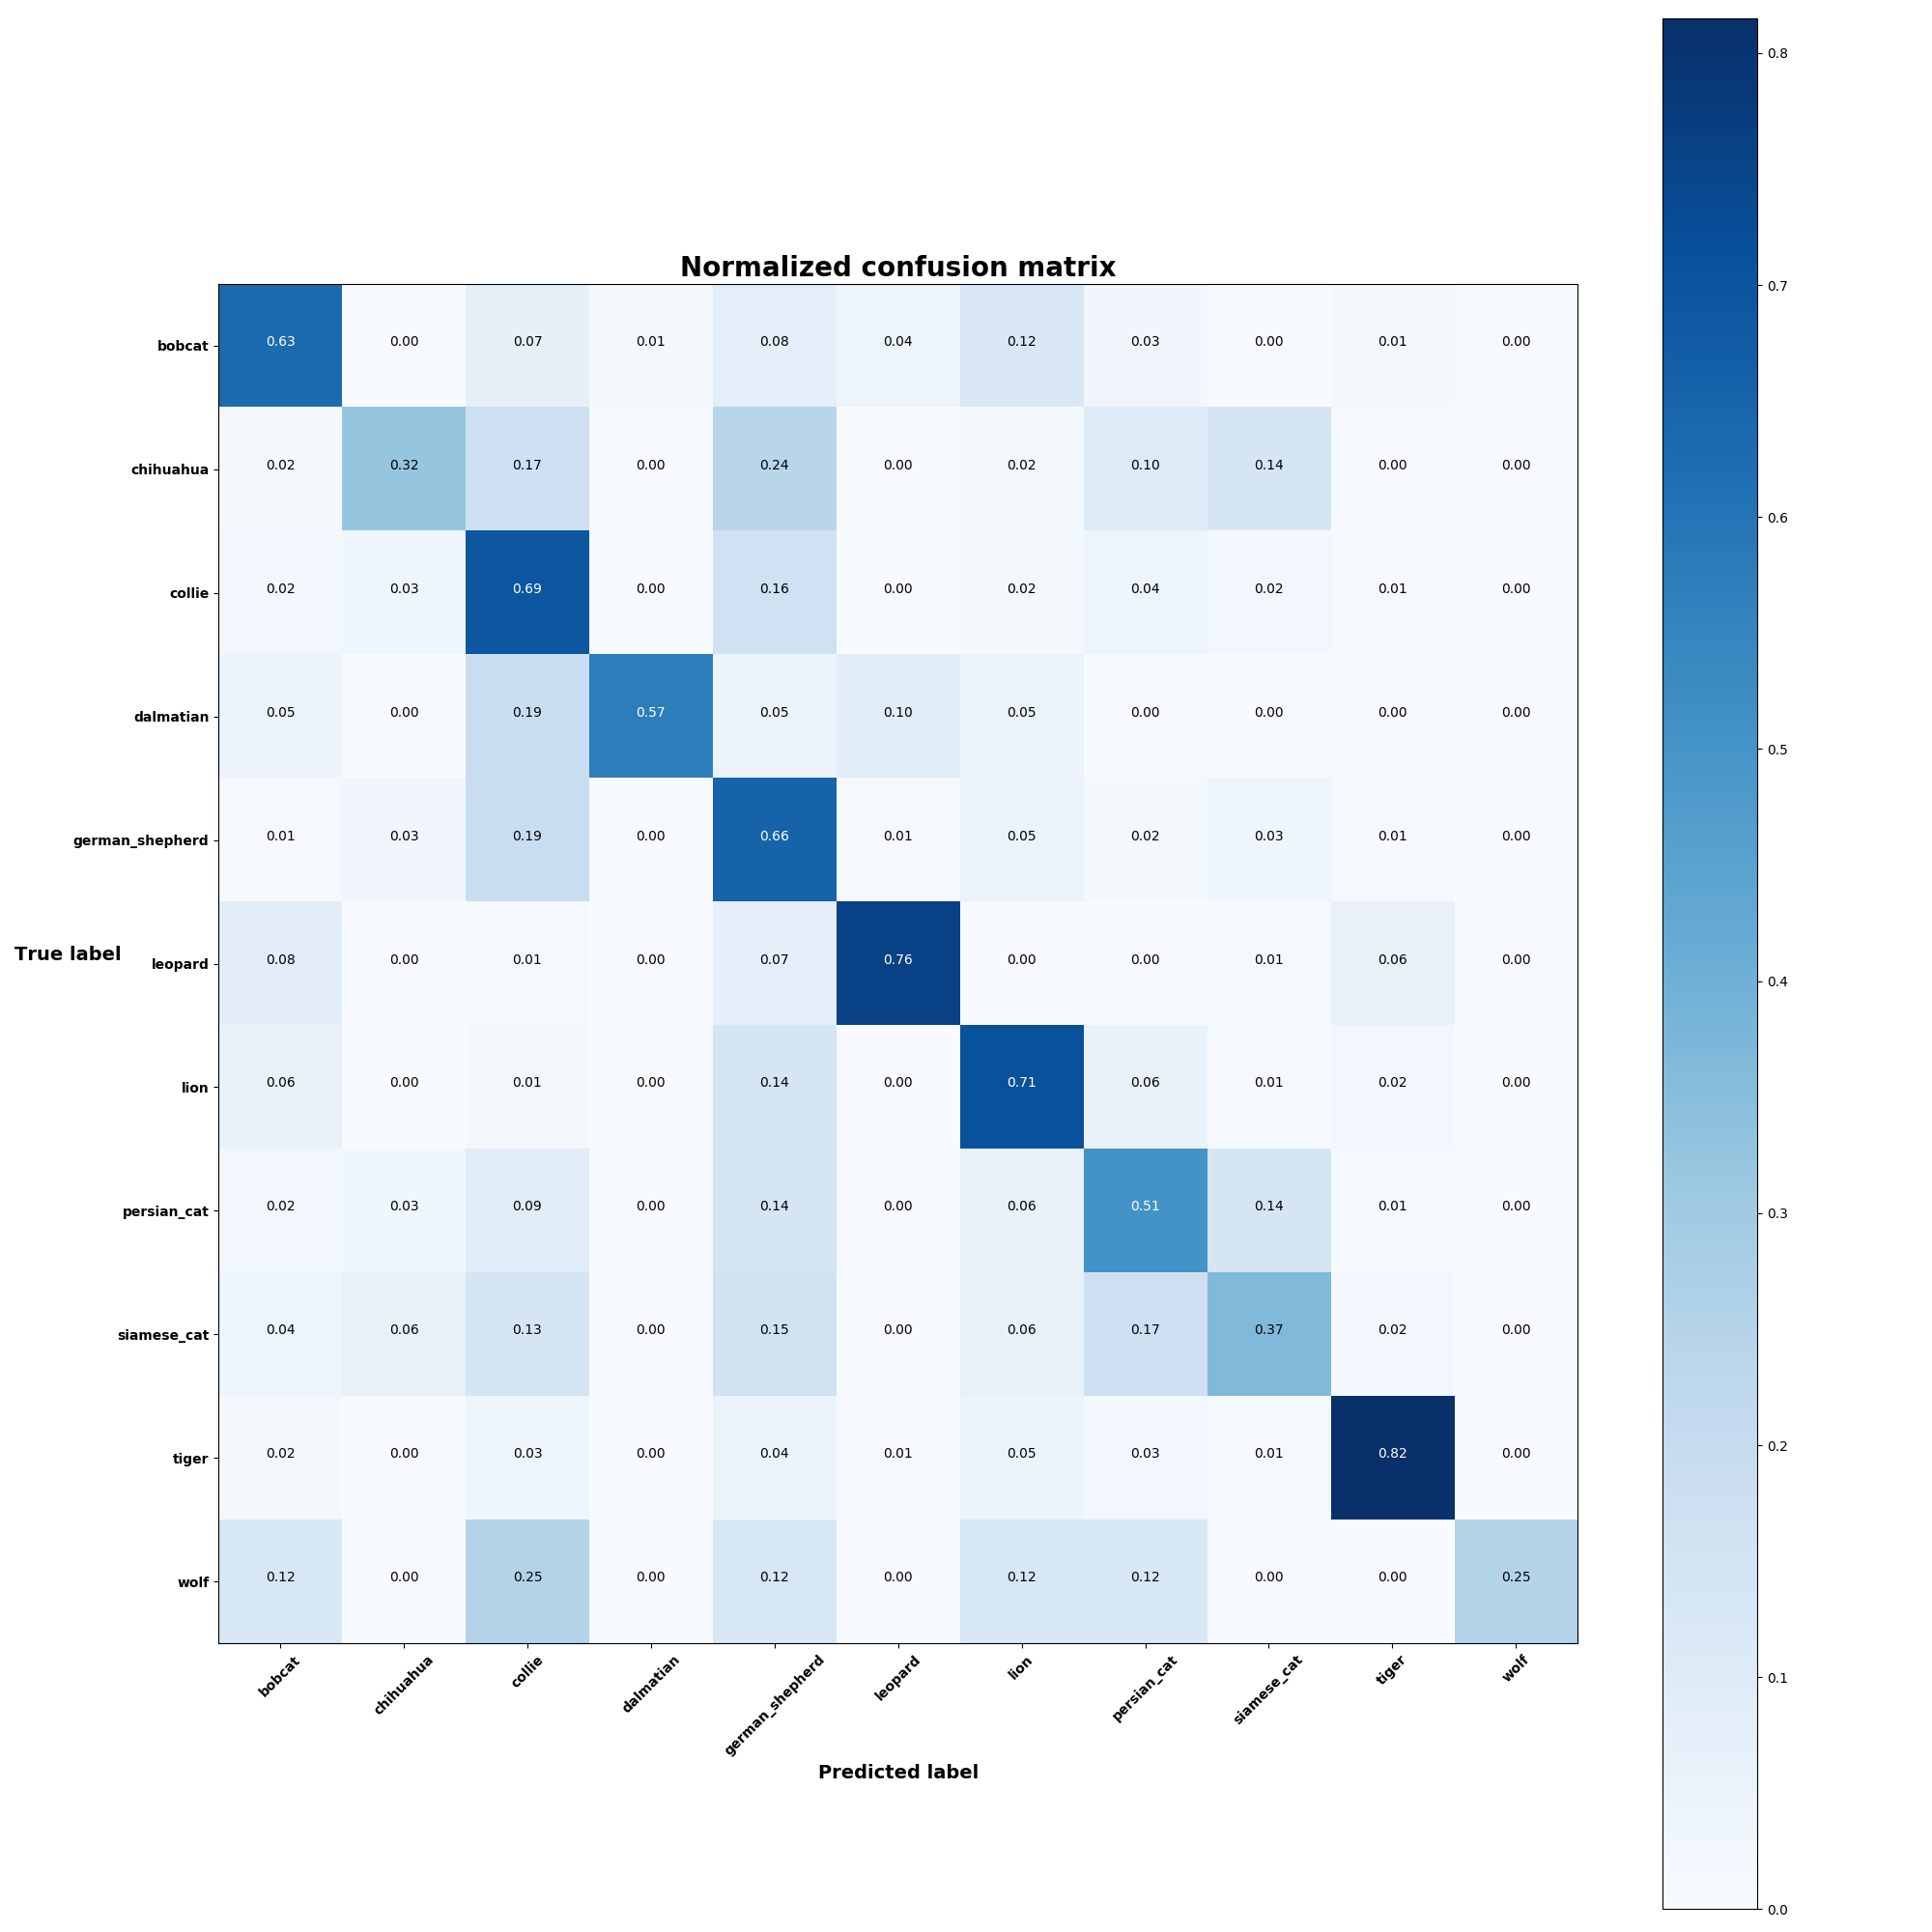

Normalized confusion matrix


In [195]:
plot_confusion_matrix(meta_model, X_train_meta, y_train_meta, X_val_meta, y_val_meta)


<IPython.core.display.Javascript object>


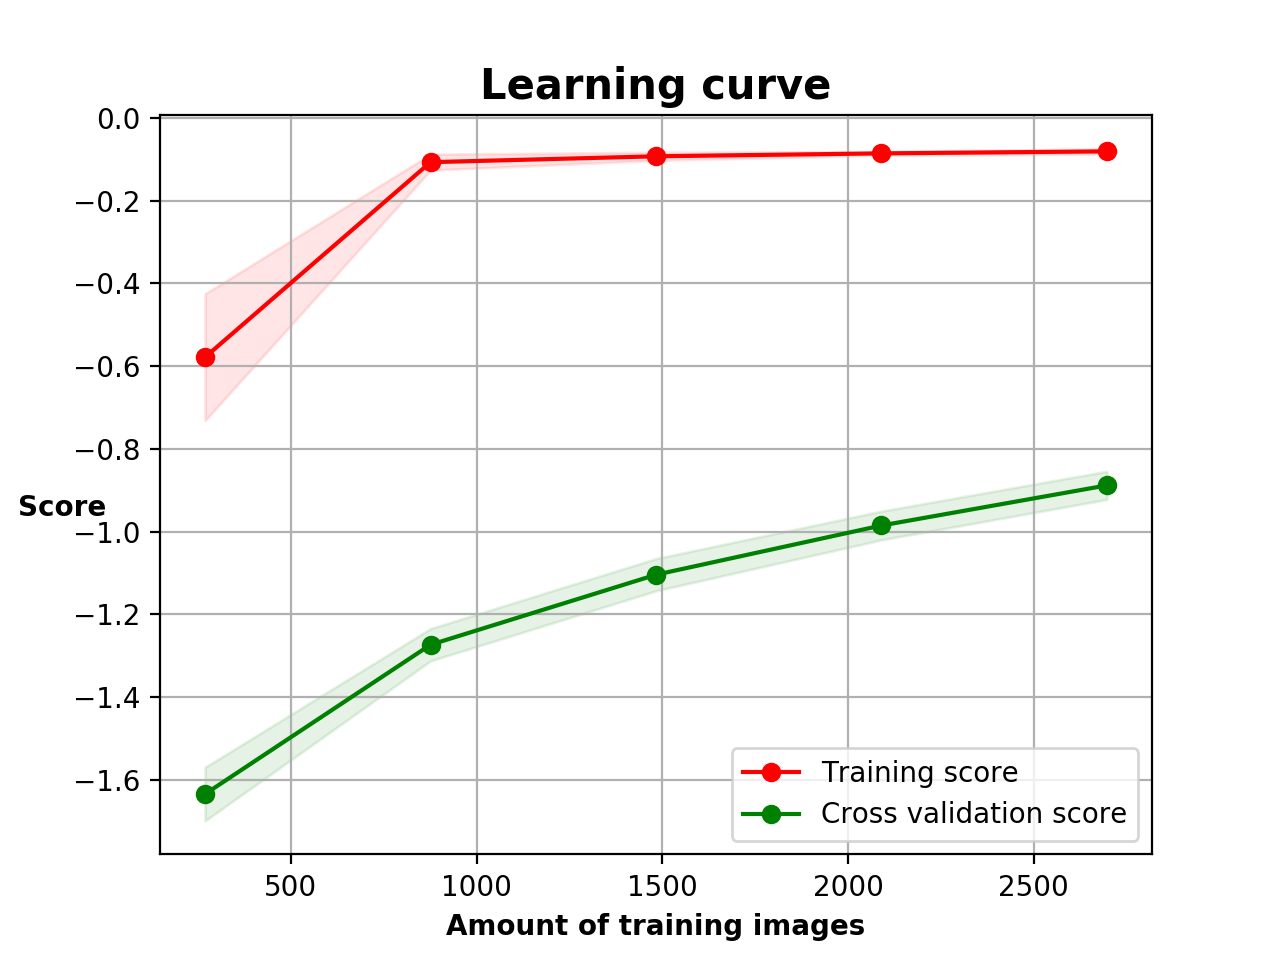

In [193]:
plot_learning_curve(meta_model, "Learning curve", X_train_meta, y_train_meta.reshape((-1, 1)), ylim=None, cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0), n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))